In [1]:
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2

In [3]:
from easydict import EasyDict
import pickle

import numpy as np
import pandas as pd
from scipy.stats import pearsonr, spearmanr, kendalltau
import matplotlib.pyplot as plt

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [4]:
def nice_results(results):
    if isinstance(results, str):
        with open(results, 'rb') as sfile:
            results = pickle.load(sfile)

    plt.figure(figsize=(6, 6))
    for (internal_id, map_size), save_dict in results.items():
        save_dict = EasyDict(save_dict)

        fr, nr = save_dict.fr, save_dict.nr        
        plt.scatter(fr, nr, s=0.5)
        plt.xlabel('rpe')
        plt.ylabel('mom')

    corrs = []
    all_fr = sum((save_dict['fr'] for save_dict in results.values()), [])
    all_nr = sum((save_dict['nr'] for save_dict in results.values()), [])

    for corr_func in [pearsonr, spearmanr, kendalltau]:
        corr = corr_func(all_fr, all_nr)
        corr = corr.statistic if hasattr(corr, "statistic") else corr.correlation
        corrs.append(corr * 100)
    print(corrs)

    return results

# SemanticKITTI

In [ ]:
## SVD planes extractor + refined transformations
svd = nice_results("SemanticKITTI-refine_ts=True-downsample-vs=0.4-upsample=False.pkl");

## SPVCNN planes extractor + refined transformations
cnnsk = nice_results("SemanticKITTI-refine_ts=True-downsample-vs=0.4-upsample=False-spvcnn.pkl");

## SPVCNN planes extractor + MoM on planes + refined transformations
cnnsk_pl = nice_results("SemanticKITTI-refine_ts=True-downsample-vs=0.4-upsample=False-spvcnn-mom_planes.pkl");

In [77]:
ALL = [svd, cnnsk, cnnsk_pl]

In [84]:
plt.rcParams['font.size'] = 12

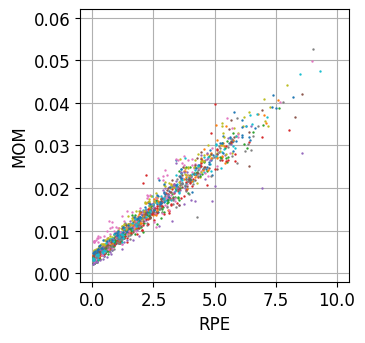

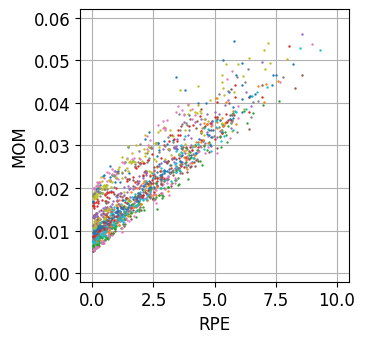

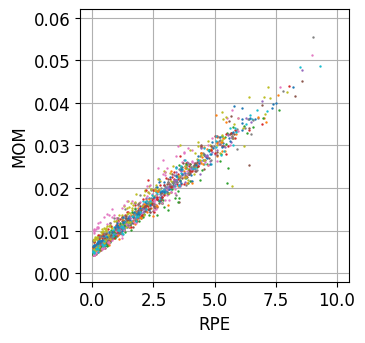

In [91]:
plt.rc('axes', axisbelow=True)

fnames = ["svd_filter", "spvcnn", "spvcnn-mom_planes"]

for results, fname in zip(ALL, fnames):
    plt.figure(figsize=(3.8, 3.6))
    for (internal_id, map_size), save_dict in results.items():
        save_dict = EasyDict(save_dict)
        fr, nr = save_dict.fr, save_dict.nr
        plt.scatter(fr, nr, s=0.5)
    plt.xlabel("RPE")
    plt.ylabel("MOM")
    plt.xlim(-0.5, 10.5)
    plt.ylim(-0.002, 0.062)
    plt.grid(True)
    plt.tight_layout()

    fname = "SemanticKITTI-" + fname + ".pdf"
    plt.savefig(fname)
    # plt.show()

In [40]:
ALLt = """26:38
15:37
11:28"""

ALLt = np.array([a * 60 + b for a, b in [map(int, x.split(':')) for x in ALLt.split('\n')]])

ALL_avg_mom_time = np.array([
    ((dut - sum(val["time_dict"]["Total time"] for key, val in du.items())) / 31 / 5 / 10)
    for du, dut in zip(ALL, ALLt)
])

ALL_avg_prep_time = [
    np.mean([val["time_dict"]["Total time"] for key, val in du.items()])
    for du in ALL
]

ALL_avg_orth_time = [
    np.mean([val["time_dict"]["Orthogonal planes extraction"] for key, val in du.items()])
    for du in ALL
]

ALL_avg_refine_time = [
    np.mean([val["time_dict"].get("Refine transformations", 0) for key, val in du.items()])
    for du in ALL
]

ALL_avg_down_time = [
    np.mean([val["time_dict"]["Downsampling"] for key, val in du.items()])
    for du in ALL
]

ALL_avg_up_time = [
    np.mean([val["time_dict"]["Upsampling"] for key, val in du.items()])
    for du in ALL
]

ALL_avg_pts_extr_time = [
    np.mean([val["time_dict"]["Point clouds planes extraction"] for key, val in du.items()])
    for du in ALL
]

ALL_avg_pts = [
    np.mean([sum(map(len, val["orth_planes"])) for key, val in du.items()])
    for du in ALL
]

corr_stats = [pearsonr, spearmanr, kendalltau]

corrs = []
for du in ALL:
    row = []
    for stat in corr_stats:
        nr = sum((val["nr"] for key, val in du.items()), [])
        fr = sum((val["fr"] for key, val in du.items()), [])
        row.append(stat(nr, fr)[0])
    corrs.append(row)
corrs = np.array(corrs)

mom_slowdown = 1 / (ALL_avg_mom_time[0] / np.array(ALL_avg_mom_time))
prep_slowdown = 1 / (ALL_avg_prep_time[0] / np.array(ALL_avg_prep_time))
orth_slowdown = 1 / (ALL_avg_orth_time[0] / np.array(ALL_avg_orth_time))
pts_extr_slowdown = 1 / (ALL_avg_pts_extr_time[0] / np.array(ALL_avg_pts_extr_time))


VS = [
    "SVD",
    "SPVCNN",
    "SPVCNN & pl.MoM"
]

REFINE_TS = [True] * 3 + [False] * 3

ALLIN = [
    VS,
    np.array(ALL_avg_orth_time) * 1000,
    orth_slowdown,
    1000 * np.array(ALL_avg_mom_time),
    mom_slowdown,
    ALL_avg_pts_extr_time,
    ALL_avg_pts,
    corrs * 100,
]

columns = [
    "Approach", "ex.or.t, ms", "ex.or.sl.d", "mom t, ms", "mom sl.d",
    "pl.ex.t, s", "#pts", "P, %", "Sp, %", "K, %"
]

ALL_COMB = np.concatenate(
    list(map(lambda x: (np.array(x) if isinstance(x[0], np.ndarray) else np.array([x]).T), ALLIN)),
    axis=1
)

COMBdf = pd.DataFrame(ALL_COMB, columns=columns)

COMBdf

In [76]:
from tabulate import tabulate

tab_kwargs = dict(
    headers=columns, tablefmt='latex_booktabs', showindex=False,
    floatfmt=["0.1f", "0.0f", "0.2f", ".0f", "0.2f", ".1f", ".0f", "0.1f", "0.1f", "0.1f"]
)

print(tabulate(COMBdf, **tab_kwargs))

\begin{tabular}{lrrrrrrrrr}
\toprule
 Approach        &   ex.or.t, ms &   ex.or.sl.d &   mom t, ms &   mom sl.d &   pl.ex.t, s &   \#pts &   P, \% &   Sp, \% &   K, \% \\
\midrule
 SVD             &           247 &         1.00 &         388 &       1.00 &          0.0 &   1454 &   97.9 &    98.0 &   87.8 \\
 SPVCNN          &           812 &         3.28 &         483 &       1.24 &          0.0 &   1878 &   90.6 &    87.7 &   70.3 \\
 SPVCNN \& pl.MoM &           766 &         3.10 &         300 &       0.77 &          1.2 &   1878 &   98.2 &    97.5 &   86.9 \\
\bottomrule
\end{tabular}
